Week 11 · Day 3 — Masking in Attention
Why this matters

In real sequences (text, time series), some positions should not influence others:

Padding mask: ignore <PAD> tokens so they don’t affect results.

Causal mask: prevent a token from looking “into the future” (for autoregressive models like GPT).

Masking ensures attention stays valid for different tasks.

Theory Essentials

Padding mask: zero out attention weights for padded tokens.

Causal mask: enforce directionality (token i can only attend to ≤ i).

Implemented by adding -inf (or a very negative number) to scores before softmax.

Shapes:

Scores shape = (queries, keys)

Mask shape = same (True = keep, False = block).

Weights with mask:
 [[0.41682121 0.34211342 0.24106536 0.         0.        ]
 [0.48890963 0.33583007 0.1752603  0.         0.        ]
 [0.14240973 0.34601857 0.51157169 0.         0.        ]]


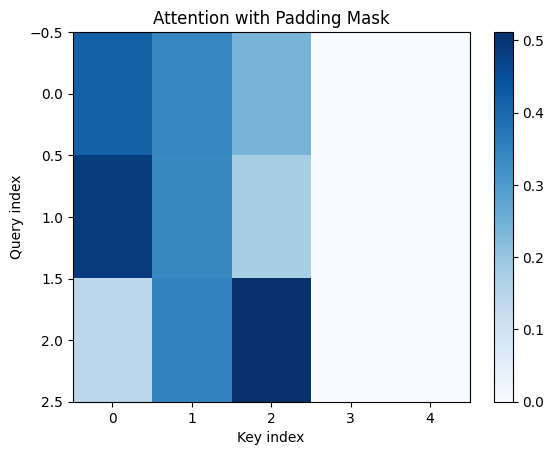

In [ ]:
# Setup
import numpy as np, matplotlib.pyplot as plt

def scaled_dot_product_attention(Q, K, V, mask=None):
    d_k = K.shape[-1]
    scores = Q @ K.T / np.sqrt(d_k)
    
    if mask is not None:
        scores = np.where(mask, scores, -1e9)  # block masked positions
    
    weights = np.exp(scores - scores.max(axis=-1, keepdims=True))
    weights /= weights.sum(axis=-1, keepdims=True)
    output = weights @ V
    return output, weights

# Example
Q = np.random.randn(3,4)   # 3 queries
K = np.random.randn(5,4)   # 5 keys
V = np.random.randn(5,4)   # 5 values

# Padding mask: last 2 keys are PAD
# This means: for every query, only the first 3 keys are valid; the last 2 are <PAD>.
# So in the attention heatmap, weights for those last 2 keys get set to ~0.
mask = np.array([[1,1,1,0,0]]*3).astype(bool)

out, w = scaled_dot_product_attention(Q,K,V,mask)

print("Weights with mask:\n", w)

plt.imshow(w, cmap="Blues", aspect="auto")
plt.colorbar()
plt.xlabel("Key index")
plt.ylabel("Query index")
plt.title("Attention with Padding Mask")
plt.show()


Padding mask: Used to ignore <PAD> tokens that were added just to make all sequences the same length in a batch. In the code, the mask sets the attention scores of padded positions to a very negative number, so after softmax their weights become ~0 and they don’t affect the output.

Causal mask: Used in autoregressive models like GPT to stop a token from “looking ahead” at future tokens. This ensures that when predicting token i, the model can only attend to tokens ≤ i. Without it, the model could cheat during training by peeking at future words.

How GPT works: ChatGPT generates text step by step. Each new token is predicted using attention over all previous tokens (restricted by the causal mask), then added to the sequence. This process repeats until the sentence is complete, which is why the text flows coherently from left to right.

1) Core (10–15 min)
Task: Change mask so that only the first 2 tokens are valid. What do weights look like?

In [2]:
mask = np.array([[1,1,0,0,0]]*3).astype(bool)
_, w = scaled_dot_product_attention(Q,K,V,mask)
print(w)


[[0.54921886 0.45078114 0.         0.         0.        ]
 [0.59280477 0.40719523 0.         0.         0.        ]
 [0.29156732 0.70843268 0.         0.         0.        ]]


2) Practice (10–15 min)
Task: Build a causal mask for sequence length 5.

In [3]:
L = 5
causal_mask = np.triu(np.ones((L,L)), k=1) == 0
print(causal_mask.astype(int))  # 1 = allowed, 0 = blocked


[[1 0 0 0 0]
 [1 1 0 0 0]
 [1 1 1 0 0]
 [1 1 1 1 0]
 [1 1 1 1 1]]


3) Stretch (optional, 10–15 min)
Task: Apply causal mask to a sequence of 5 tokens (Q=K=V). Verify that row i only attends to ≤ i.

In [4]:
Q = K = V = np.random.randn(5,4)
mask = np.triu(np.ones((5,5)), k=1) == 0
_, w = scaled_dot_product_attention(Q,K,V,mask)
print(w.round(2))


[[1.   0.   0.   0.   0.  ]
 [0.16 0.84 0.   0.   0.  ]
 [0.34 0.09 0.57 0.   0.  ]
 [0.07 0.23 0.24 0.45 0.  ]
 [0.04 0.25 0.1  0.27 0.35]]


Mini-Challenge (≤40 min)

Build: A demo that switches between no mask, padding mask, and causal mask, showing the attention heatmap for each.
Acceptance Criteria:

Functions for each mask type.

Heatmaps clearly showing differences.

Causal mask must block “future” positions.

Weights with padding  mask:
 [[0.60196518 0.18309972 0.2149351  0.         0.        ]
 [0.47041399 0.10332021 0.4262658  0.         0.        ]
 [0.11876364 0.41131906 0.46991729 0.         0.        ]
 [0.63125953 0.01499411 0.35374636 0.         0.        ]
 [0.03920774 0.89359028 0.06720199 0.         0.        ]]


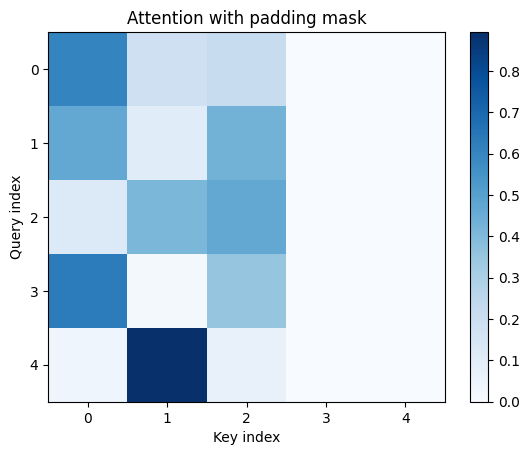

Weights with casual  mask:
 [[1.         0.         0.         0.         0.        ]
 [0.81991625 0.18008375 0.         0.         0.        ]
 [0.11876364 0.41131906 0.46991729 0.         0.        ]
 [0.20970188 0.00498098 0.11751312 0.66780402 0.        ]
 [0.03708759 0.8452697  0.06356806 0.04948635 0.00458829]]


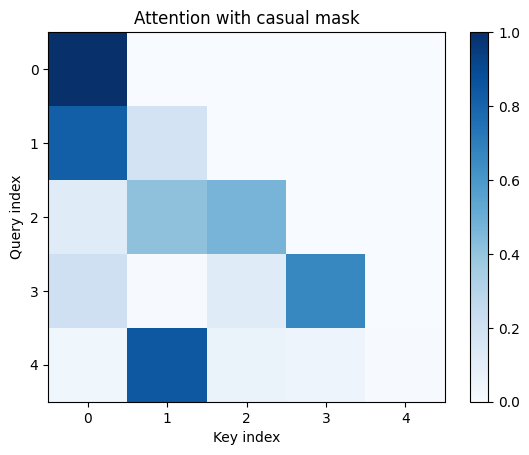

Weights with no  mask:
 [[0.31609387 0.09614626 0.11286312 0.14048573 0.33441101]
 [0.16048536 0.03524849 0.14542387 0.15619327 0.50264901]
 [0.08896301 0.30810928 0.35200382 0.13358651 0.11733738]
 [0.17251006 0.00409758 0.0966715  0.5493652  0.17735566]
 [0.03708759 0.8452697  0.06356806 0.04948635 0.00458829]]


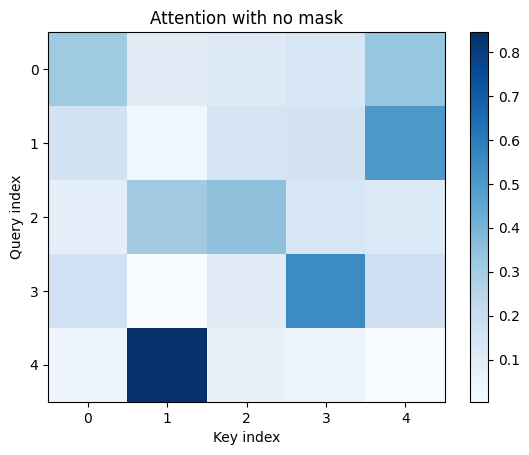

In [9]:


# Example
Q = np.random.randn(5,4)   # 5 queries
K = np.random.randn(5,4)   # 5 keys
V = np.random.randn(5,4)   # 5 values

d_k = K.shape[-1]
scores = Q @ K.T / np.sqrt(d_k)

for mask in ["padding", "casual", "no"]:

    scores = Q @ K.T / np.sqrt(d_k)

    if mask == "padding":

        mask_p = np.array([[1,1,1,0,0]]*5).astype(bool)
        scores = np.where(mask_p, scores, -1e9)

    elif mask == "casual":
        mask_c = np.triu(np.ones((5,5)), k=1) == 0
        scores = np.where(mask_c, scores, -1e9)

    weights = np.exp(scores - scores.max(axis=-1, keepdims=True))
    weights /= weights.sum(axis=-1, keepdims=True)
    output = weights @ V

    print("Weights with", mask, " mask:\n", weights)

    plt.imshow(weights, cmap="Blues", aspect="auto")
    plt.colorbar()
    plt.xlabel("Key index")
    plt.ylabel("Query index")
    plt.title(f"Attention with {mask} mask")
    plt.show()

Notes / Key Takeaways

Masks prevent invalid tokens from influencing attention.

Padding mask handles variable-length batches.

Causal mask enables autoregressive generation (like GPT).

Implementation trick: add -inf before softmax.

Heatmaps make masking effects obvious.

Reflection

Why do we add -inf (or a large negative number) before softmax instead of just zeroing scores?

How does masking enable GPT to generate text one token at a time without cheating?

We add –∞ (or a very large negative number) before softmax instead of just zeroing scores because softmax always turns every input into a positive probability. By setting blocked positions to –∞, their exponent becomes 0, so their weight is guaranteed to be exactly 0 after softmax.

Masking enables GPT to generate text one token at a time without cheating by blocking attention to future tokens. Each token can only attend to itself and past tokens, so when GPT predicts the next word, it uses only the context already written — not words from the future.